In [1]:
import os
import pickle

import torch
import numpy as np
import pandas as pd
import sciplots as plots

from src.utils.data import DarkDataset
from src.utils.utils import open_config, ROOT
from src.utils import analysis, plot_config

In [12]:
_, config = open_config('main', os.path.join(ROOT, '../config.yaml'))

net_epochs = config['training']['epochs']
plots_dir = os.path.join(ROOT, config['output']['plots-directory'], 'final_plots')
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)
colours = np.array(plot_config.BAHAMAS[:1] + ['k'] + plot_config.BAHAMAS[2:])

In [15]:
dataset = DarkDataset(
    config['data']['data-dir'],
    ['bahamas_cdm', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1'],
    [],
    cdm_sigma=1e-3,
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
dataset.high_dim.shape

(14400, 3, 100, 100)

In [5]:
with open(os.path.join(ROOT, '../data/cdm_1.pkl'), 'rb') as file:
    data = pickle.load(file)

data['net'] = np.empty_like(data['net_path'], dtype=object)

for i, net_path in enumerate(data['net_path']):
    data.loc[i, 'net'] = torch.load(net_path, map_location='cpu')

In [6]:
nets = data['net'].to_numpy().reshape(-1, 3)
nets.shape

(6, 3)

In [ ]:
torch.manual_seed(0)
np.random.seed(0)
predictions = analysis.gen_predictions(
    config['training']['batch-size'],
    config['training']['validation-fraction'],
    nets,
    dataset,
)

In [8]:
data_pred, distributions, new_distributions, grids, probs, quantiles = analysis.probs_distributions(
    quantile_values,
    predictions,
    nets,
    dataset,
)
quantiles = np.concat((quantiles, [quantiles[0] - quantiles[2], quantiles[3] - quantiles[0]]), axis=0)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((6, 3, 4), (6, 4, 500), (6, 500), (6, 4, 500), (7, 6, 4))

Architecture: CompactClusterEncoder
Description: Sims: ['bahamas_cdm' 'bahamas_0.3' 'bahamas_1']
Unknown Sims: ['bahamas_0.1']
CDM Sigma: 0.1
Version: 3.9.1
Network: network_v10
Epoch: 150
Optimiser: AdamW
Scheduler: OneCycleLR
Args: (method: median, center_step: [1.0, 1.0, 1.0, 1.0], similarity_weight: 0, class_weight: 1, compact_weight: 0, distance_weight: 1, steps: 3, cluster_weight: 2.2)


,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.10245,0.06839,0.07907,0.12346,0.14126,0.02338,0.02101
BAHAMAS-0.1,0.13553,0.09430,0.10790,0.18494,0.24214,0.02763,0.04942
BAHAMAS-0.3,0.27706,0.13836,0.17743,0.45562,0.66164,0.09962,0.17856
BAHAMAS-1,1.07685,0.52132,0.73389,1.53172,1.96424,0.34296,0.45487


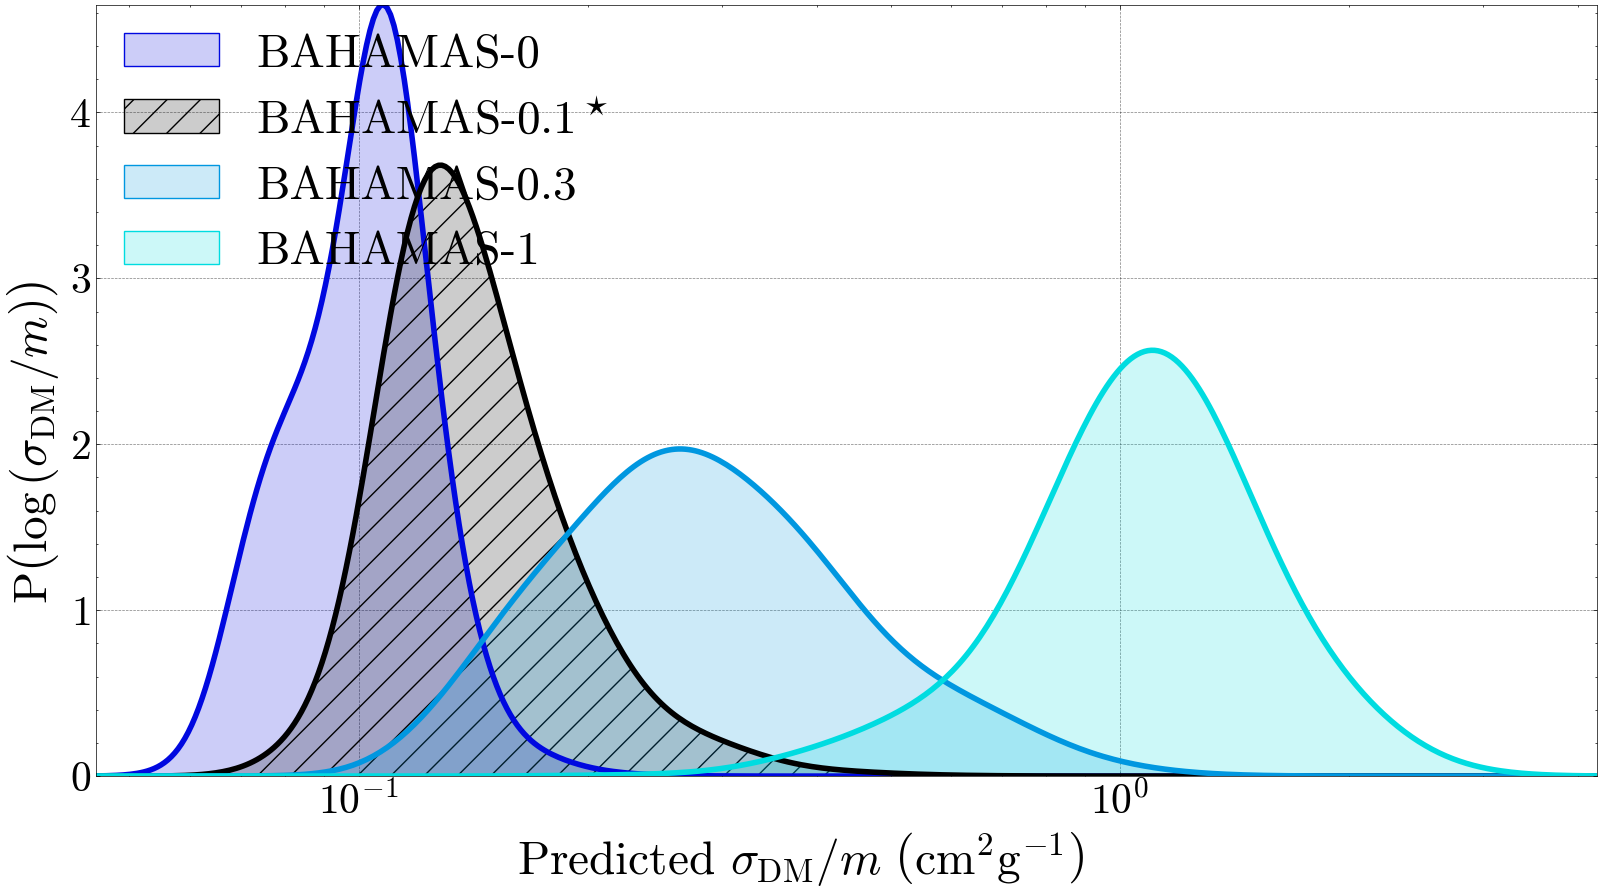

In [9]:
idx = (4,)
styles = np.array(['-'] * len(labels), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels.copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    # label_permute=[0, 1, 3, 2],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
print(nets[*idx, 0])
pd.DataFrame(quantiles[:, *idx].swapaxes(0, 1), index=labels, columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

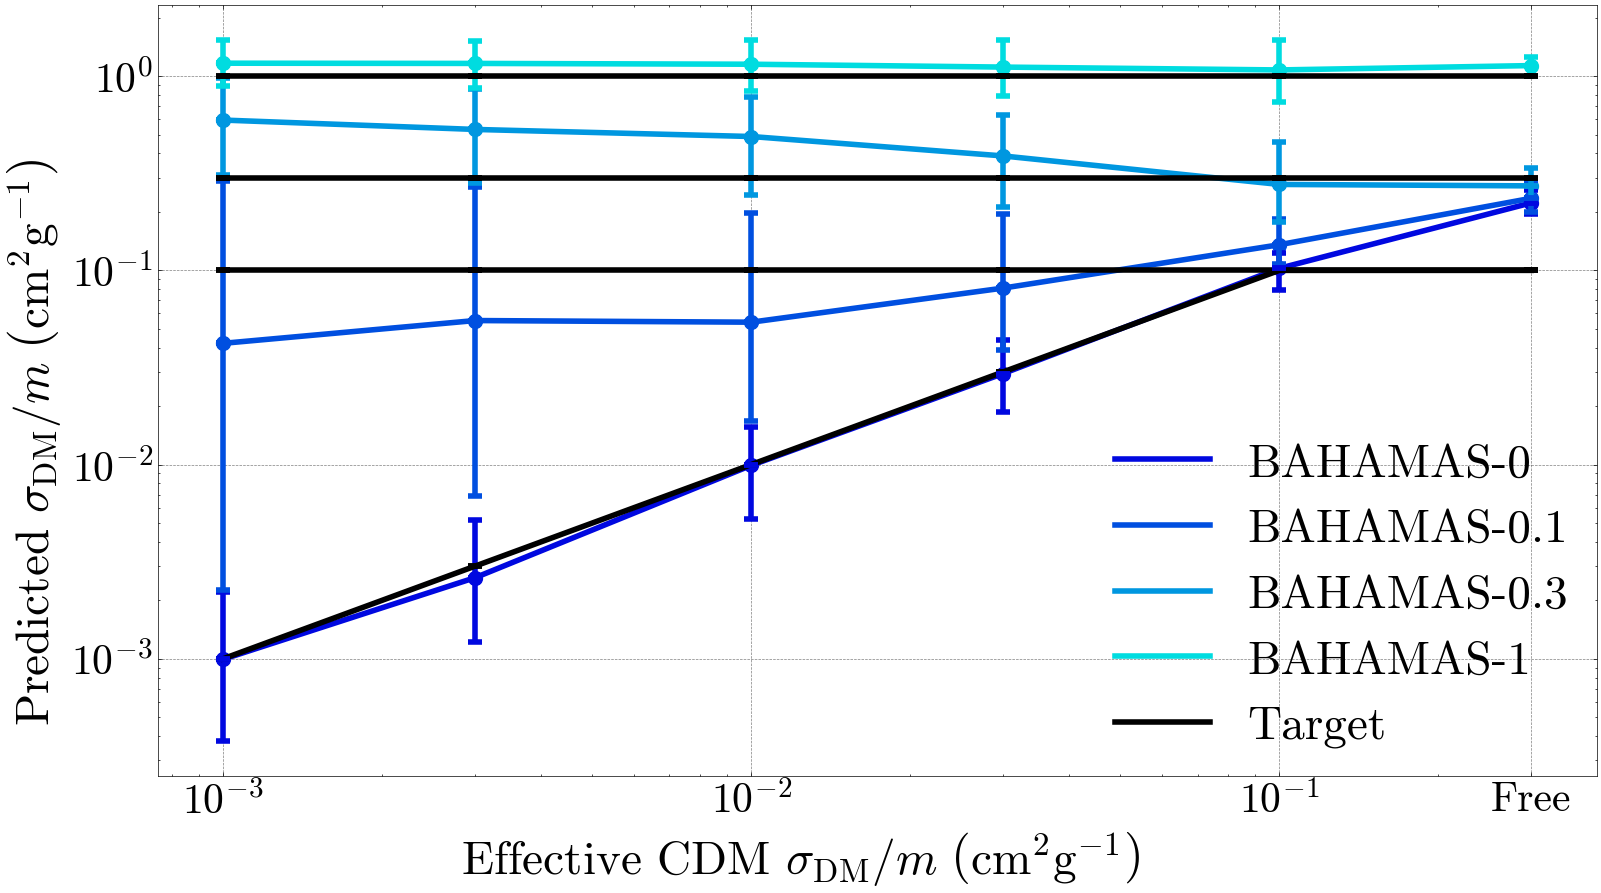

In [10]:
x_data = np.array([1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1])
plot = plots.PlotPlots(
    x_data,
    [
        *quantiles[0].swapaxes(0, 1),
        np.clip(x_data, a_min=None, a_max=0.1),
        *np.ones((quantiles.shape[-1] - 1, len(x_data))) * np.array([0.1, 0.3, 1])[:, None],
        *quantiles[0].swapaxes(0, 1),
    ],
    log_x=True,
    log_y=True,
    x_label=r'Effective CDM $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    styles=['-'] * quantiles.shape[-1] * 2 + ['o'] * quantiles.shape[-1],
    labels=[*labels, 'Target', *[''] * (quantiles.shape[-1] * 2 - 1)],
    y_error=[*quantiles[-2:].transpose(-1, 0, 1), *np.zeros((quantiles.shape[-1] * 2, len(x_data)))],
    # colours=[*np.array(plot_config.BAHAMAS)[[1, 0, 2, 3]], *['k'] * 4],
    colours=[*plot_config.BAHAMAS, *['k'] * 4, *plot_config.BAHAMAS],
    marker_size=100,
    line_width=4,
    eline_width=4,
    alpha_marker=1,
    major=plot_config.MAJOR,
    minor=plot_config.MINOR,
    axis=True,
    frameon=False,
    cols=1,
    loc='best',
    # label_permute=[1, 0, 2, 3, 4],
)
plot.axes.set_xticks([1e-3, 1e-2, 1e-1, 3e-1])
plot.axes.set_xticklabels([r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', 'Free'])
plot.set_axes_pad(0.05)